BOLLINGER BANDS 'W' PATTERN TRADING STRATEGY
Date: 08-11-2023
Author : Deepa Navaneeth

Based on the price movements, Bollinger Bands provides the trader with the sense of market direction. 
Bollinger Bands consist of three lines: a middle band (usually a 20-period simple moving average) and 
two outer bands that are typically set to two standard deviations away from the middle band. 
These outer bands create the volatility range.

'W' pattern is a technical analysis pattern used in charting where it identifies an alteration in a 
trend and a turnaround in the momentum from previous price action.

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import quantstats as qs
import pyfolio as pf

In [7]:
def bollinger_bands(df):
    data = copy.deepcopy(df)
    data['STD'] = data['price'].rolling(window = 20,min_periods = 20).std()
    data['mid band'] = data['price'].rolling(window = 20,min_periods = 20).mean()
    data['upper band'] = data['mid band'] + 2*data['STD']
    data['lower band'] = data['mid band'] - 2*data['STD']
    return data

W PATTERN STRATEGY : The formation’s first bottom is characterised by a sharp price pullback that closes outside of the lower Bollinger Band. These kinds of moves usually result in what is known as an “automatic rally.” The automatic rally’s high usually serves as the first level of resistance in the base-building process before the stock moves higher. 

After the rally begins, the price attempts to retest the most recent lows in order to test the strength of the buying pressure that came in at that bottom.The 5 nodes of the W shape has certain conditions set that determines when to enter and exit the trade. 

In [11]:
def Generate_Signal(data,indicator):
    # Period denotes the length of the window. Double Bottom pattern wall is 75.
    period=75
    
    #Alpha : The difference between price and Bollinger Bands
    #if alpha is too small, its unlikely to trigger a signal
    #if alpha is too large, its too easy to trigger a signal
    #which gives us a higher probability to lose money
    
    #Beta : The scale of bandwidth
    #when bandwidth is larger than beta, it is expansion period
    #when bandwidth is smaller than beta, it is contraction period
    
    alpha=0.0001
    beta=0.0001
    
    df=indicator(data)
    df['signals']=0
    
    #coordinates store five nodes of w shape - top_node,first_bottom_node,middle_node,second_bottom_node,top_right
    # Refer to the picture in the report -Trading_strategies\Bollinger_Pattern.png
    #The coordinates are used to draw a 'w' shape
    df['cumsum']=0
    df['coordinates']=''
    
    for top_right in range(period,len(df)):
    
        #if moveon==true, we move on to verify the next condition
        #if false, we move on to the next iteration
        #threshold denotes the value of node first_bottom_node
        #we would use it for the comparison with node second_bottom_node
    
        moveon=False
        threshold=0.0
        
        #bottom w pattern recognition
        #condition 4
        if (df['price'][top_right]>df['upper band'][top_right]) and \
        (df['cumsum'][top_right]==0):
            
            for middle_node in range(top_right,top_right-period,-1):                
                
                #condition 2
                if (np.abs(df['mid band'][middle_node]-df['price'][middle_node])<alpha) and \
                (np.abs(df['mid band'][middle_node]-df['upper band'][top_right])<alpha):
                    moveon=True
                    break
            
            if moveon==True:
                moveon=False
                for first_bottom_node in range(middle_node,top_right-period,-1):
                    
                    #condition 1
                    if (np.abs(df['lower band'][first_bottom_node]-df['price'][first_bottom_node])<alpha):
                        threshold=df['price'][first_bottom_node]
                        moveon=True
                        break
                        
            if moveon==True:
                moveon=False
                for top_node in range(first_bottom_node,top_right-period,-1):
                    
                    #this one is for plotting w shape
                    if (df['mid band'][top_node]<df['price'][top_node]):
                        moveon=True
                        break
                    
            if moveon==True:
                moveon=False        
                for second_bottom_node in range(top_right,middle_node,-1):
                    
                    #condition 3
                    if (df['price'][second_bottom_node]-df['lower band'][second_bottom_node]<alpha) and \
                    (df['price'][second_bottom_node]>df['lower band'][second_bottom_node]) and \
                    (df['price'][second_bottom_node]<threshold):
                        df.at[top_right,'signals']=1
                        df.at[top_right,'coordinates']=f'{top_node},{first_bottom_node},{middle_node},{second_bottom_node},{top_right}'
                        df['cumsum']=df['signals'].cumsum()
                        moveon=True
                        break
        
        if (df['cumsum'][top_right]!=0) and \
        (df['STD'][top_right]<beta) and \
        (moveon==False):
            df.at[top_right,'signals']=-1
            df['cumsum']=df['signals'].cumsum()
       
    return df

In [9]:
def plot(plot_df):
    entry,exit = list(plot_df[plot_df['signals']!=0].iloc[:2].index)
    selected_df = plot_df[entry-85:exit+30]
    selected_df.set_index(pd.to_datetime(selected_df['date'],format='%Y-%m-%d %H:%M:%S'),inplace=True)

    fig = plt.figure(figsize=(20,10))
    axis = fig.add_subplot(111)
    
    # plotting on price series and Bollinger Bands
    axis.plot(selected_df['price'],lw=2,c='black')
    axis.plot(selected_df['mid band'],lw=2,linestyle='--',label='moving average',c='#132226')
    axis.plot(selected_df['upper band'],lw=2,c='green',label = 'upper band')
    axis.plot(selected_df['lower band'],lw=2,c='red',label = 'lower band')
    axis.fill_between(selected_df.index,selected_df['lower band'],selected_df['upper band'],alpha=0.2,color='#FFFF00')
    axis.plot(selected_df['price'][selected_df['signals']==1],marker='^',markersize=15,lw=0,c='g',label='LONG')
    axis.plot(selected_df['price'][selected_df['signals']==-1],marker='v',markersize=15, \
            lw=0,c='r',label='SHORT')
    
    #plotting the "W" shape
    temp=selected_df['coordinates'][selected_df['signals']==1]
    indexlist=list(map(int,temp[temp.index[0]].split(',')))
    axis.plot(selected_df['price'][pd.to_datetime(plot_df['date'].iloc[indexlist])], \
            lw=5,alpha=0.7,c='#FE4365',label='double bottom pattern')
    
    # Captions / Legends
    plt.text((selected_df.loc[selected_df['signals']==1].index[0]), \
             selected_df['lower band'][selected_df['signals']==1],'Expansion',fontsize=15,color='#563838')
    plt.text((selected_df.loc[selected_df['signals']==-1].index[0]), \
             selected_df['lower band'][selected_df['signals']==-1],'Contraction',fontsize=15,color='#563838')
    
    plt.legend(loc='best')
    plt.title('Bollinger Bands W-Pattern trading Strategy')
    plt.ylabel('price')
    plt.grid(True)
    plt.show()

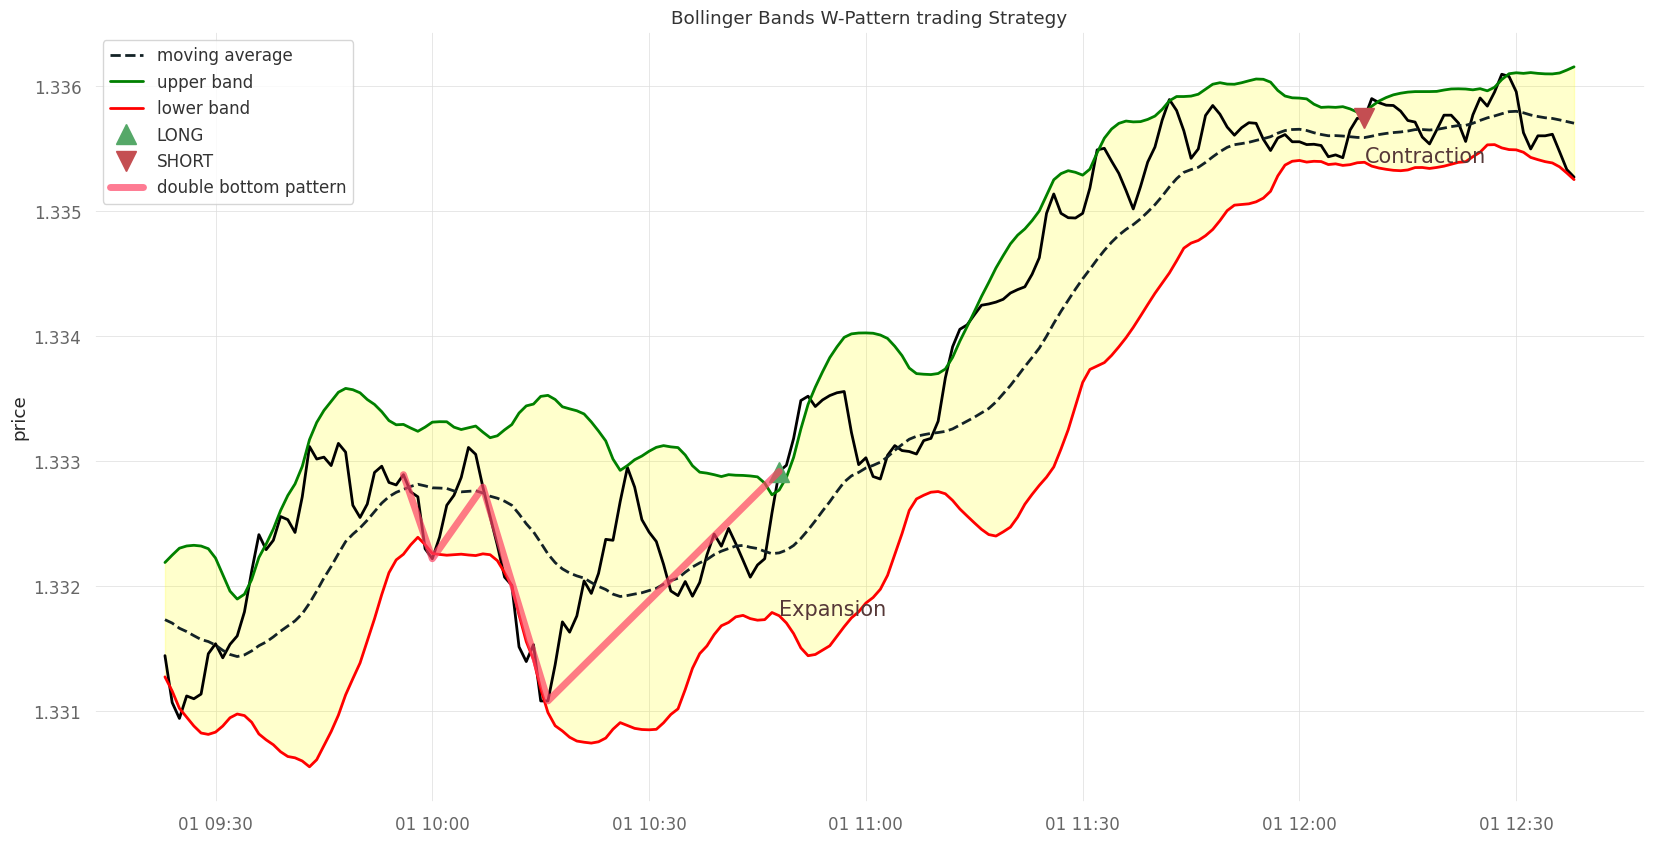

In [10]:
      
def main():
    df=pd.read_csv("/home/deepa/Trading_strategies/gbpusd.csv")
    
    signals=Generate_Signal(df,bollinger_bands)

    plot_df = copy.deepcopy(signals)
    plot(plot_df)

if __name__=="__main__":
    main()